In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
# patch start [https://stackoverflow.com/questions/16488182/removing-axes-margins-in-3d-plot]
from mpl_toolkits.mplot3d.axis3d import Axis
def _get_coord_info_new(self, renderer):
    mins, maxs, cs, deltas, tc, highs = self._get_coord_info_old(renderer)
    correction = deltas * [1.0/4 + 6.0/11,
                           1.0/4 + 6.0/11,
                           1.0/4]
    mins += correction
    maxs -= correction
    return mins, maxs, cs, deltas, tc, highs
if not hasattr(Axis, "_get_coord_info_old"):
    Axis._get_coord_info_old = Axis._get_coord_info  
Axis._get_coord_info = _get_coord_info_new
#patch end
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

## Solving the heat diffusion equation

We want to solve the [heat equation](https://en.wikipedia.org/wiki/Heat_equation)

$$
\frac{\partial u}{\partial t}= a^2 \frac{\partial^2 u}{\partial x^2},
$$

or

$$
\frac{\partial u}{\partial t} = \dot{u} = u_{t} = a^2 u_{xx} = a^2 \frac{\partial^2 u}{\partial x^2} = a^2 \triangle u = a^2 \nabla^2 u,
$$

where we just showed how many different styles of notation have been invented describing partial differential equations. 

So we think of having a 1-dimensional function $u(x)$.
Its Fourier transform we denote as $\hat{u}(\kappa)$. 

To remind myself what happens at integration or differentiation I think of terms proportional to 
$$
e^{i\kappa x}
$$

So, the second derivative with respect to position, $x$, brings down the factor $i\kappa$ two times, so $(i\kappa)^2=-\kappa^2$. 
Consequently if we apply the Fourier transform to both sides of our equation we arrive at

$$
{d\hat{u}(\kappa) \over dt} =  - a^2 \kappa^2 \hat{u}(\kappa).
$$

Wow. This says that the Fourier coefficients $\kappa$ all just decay independently of each other. You can see this because the equation is 

$$
\frac{df(x,t)}{dt} = -a x^2 f(x,t),
$$

which is solved by $f(x,0) e^{-a x^2 t}$ or for our case $\hat{u}(\kappa)(t) = \hat{u}(\kappa)(t=0) e^{-a^2 \kappa^2 t}$.

This is exactly why Fourier worked on this and how he managed to solve this equation. 
So in principle we would not have to do this numerically but we use this as our first example to demonstrate how this solution strategy is implemented in code. 
Once we know this we can "graduate" to use a similar strategy for more complex equations. 

In [2]:
a = 0.5    # Thermal diffusivity constant
L = 2     # Length of domain
Tfinal = 1.

N = 1024 # Number of spatial discretization points
Nt = 100 # Number of time outputs

dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wave-numbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = np.zeros_like(x)    # same shape as spatial grid
u0[np.abs(x)<=0.25] = 1  # square shape pulse 
u0hat = np.fft.fft(u0)   # ICs in Fourier space

# Simulate in Fourier frequency domain
t = np.linspace(0, Tfinal, Nt)

def rhsHeat(t, uhat, kappa,a):
    d_uhat = -a**2 * kappa**2 * uhat
    return d_uhat

sol = solve_ivp(rhsHeat, (t[0],t[-1]), u0hat, args=(kappa,a), t_eval=t )

u = np.zeros_like(sol.y)

# Fourier transform the solution back to configuration space 
for ct in range(len(t)):
    u[:,ct] = np.fft.ifft(sol.y[:,ct])

u = u.real

In [3]:
def heat_analytic_fourier(u0hat, kappa, a, t):
    return  u0hat * np.exp(-(kappa**2 * a**2 * t))

ua = np.zeros_like(sol.y)
uahat = np.zeros_like(sol.y)

# Fourier transform the solution back to configuration space 
for i, ct in enumerate(t):
    uahat[:,i] = heat_analytic_fourier(u0hat, kappa, a, ct)
    ua[:,i] = np.fft.ifft(uahat[:,i])

ua = ua.real

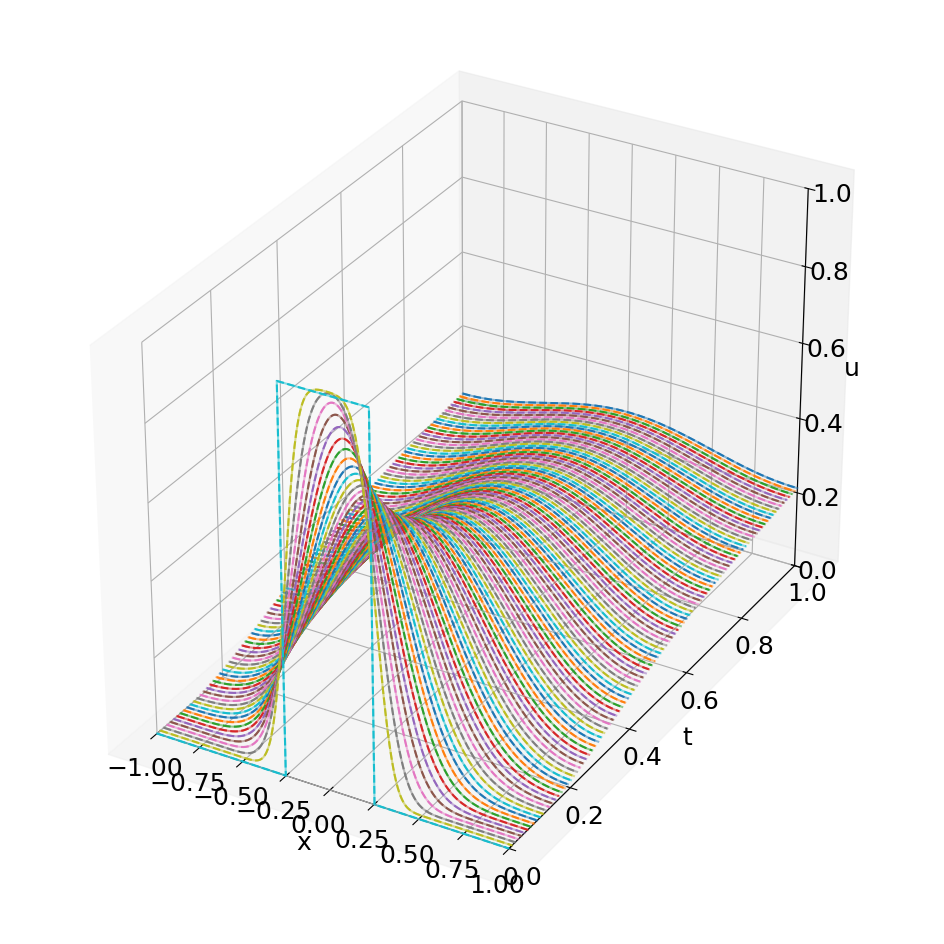

In [4]:
# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for j in range(u.shape[1]-1,-1,-1):
    ys = t[j]*np.ones(u.shape[0])
    color = next(ax._get_lines.prop_cycler)['color'] # cool trick to keep color 
    ax.plot(x,ys,ua[:,j],color=color,alpha=0.5) # analytic solution
    ax.plot(x,ys,u[:,j],'--',color=color)       # our solution
    
plt.xlabel("x")
plt.ylabel("t")

ax.set_zlabel("u")
ax.set_box_aspect([1, 1.5, 1])

This is called a Waterfall plot. It shows the spatial and temporal evolution in a single Figure. The solid line is the analytic solution and the dashed curves give the one from integration using ```solve_ivp```. 
Alternatively we can use a surface plot.

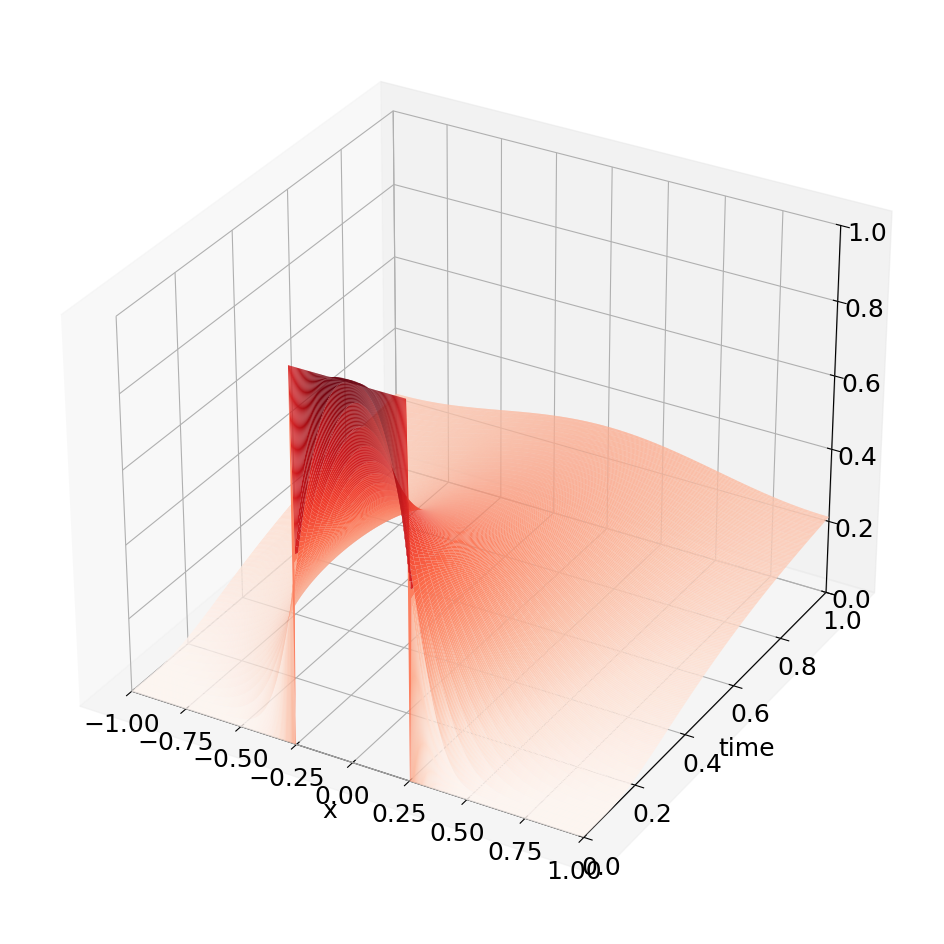

In [5]:
X, Y = np.meshgrid(x, t)
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, u.T,  cmap="Reds", antialiased=True, rstride=2,cstride=2);
ax.set_xlabel("x")
ax.set_ylabel("time");

Or an image where the colorvalue is our solution variable:

<Figure size 1200x1200 with 0 Axes>

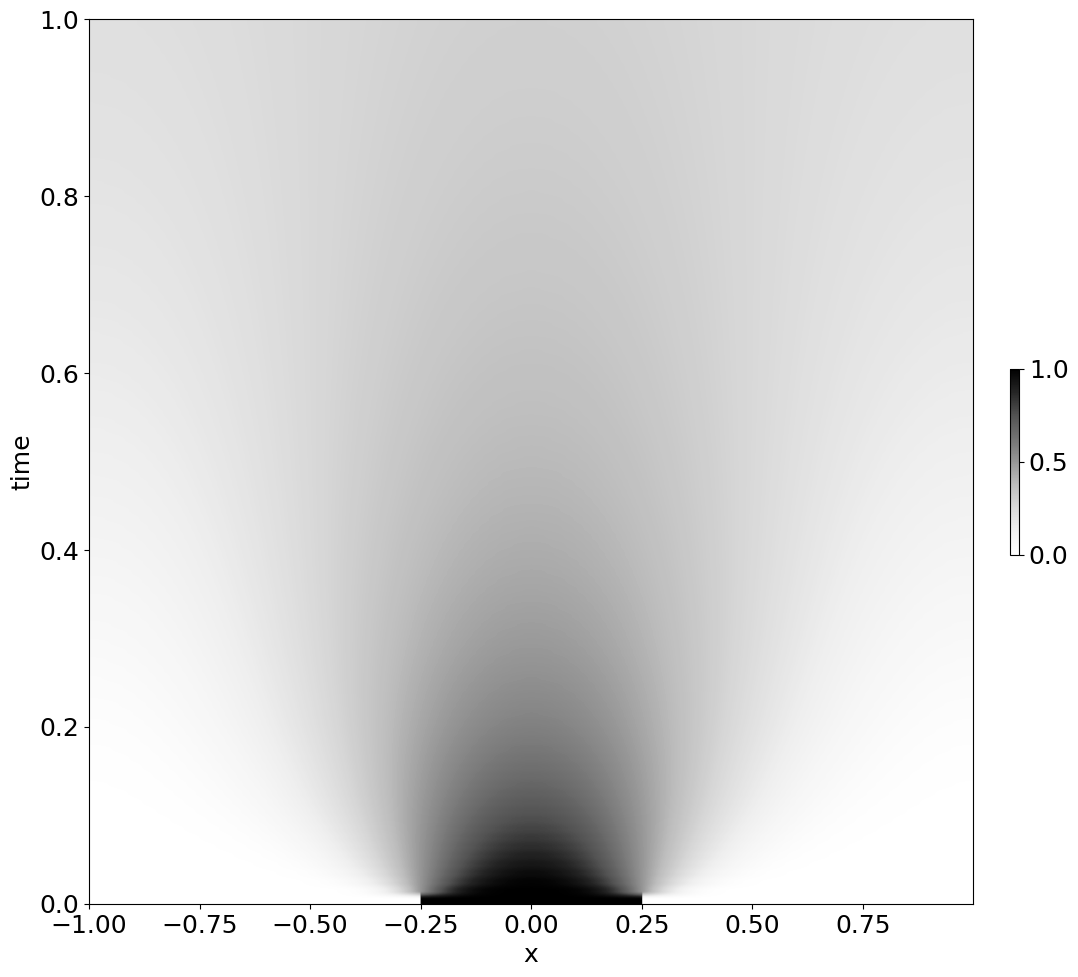

In [6]:
# Image plot
plt.figure()
fig, ax = plt.subplots()
im = ax.imshow(np.flipud(u.T),extent=[x[0],x[-1],t[0],t[-1]], aspect=2,cmap="Greys")
ax.set_xlabel("x")
ax.set_ylabel("time")
fig.colorbar(im,fraction=0.01,pad=0.04);
plt.show();

## Propagating wave equation

Now let's try the propagating wave equation:

$$
u_t - c u_x = 0
$$

or 

$$
\frac{\partial u}{\partial t} - c \frac{\partial u}{\partial x} = 0
$$


which looks like

$$
{d \hat{u}(\kappa) \over dt} = c {du(x) \over dx} = - i\kappa\, c\, \hat{u}(\kappa)
$$

after Fourier transform. Again we Fourier modes evolving independently of each other. This time it is also exponential but with a complex exponent that shifts the phase. 

In [7]:
c = -2    # Wave speed
L = 2   # Length of domain
N = 1024 # Number of discretization points
Nt = 100
Tfinal = 1

dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x/(L/20))
u0hat = np.fft.fft(u0)

# Simulate in Fourier frequency domain
t = np.linspace(0, Tfinal, Nt)

# in fourier domain
def rhsWave(t, uhat, kappa,c):
    d_uhat = -c*(1j)*kappa*uhat
    return d_uhat

sol = solve_ivp(rhsWave, (t[0],t[-1]), u0hat, args=(kappa,c), t_eval=t)
uhat = sol.y
# Inverse FFT to bring back to spatial domain
u = np.zeros_like(uhat)
for k in range(len(t)):
    u[:,k] = np.fft.ifft(uhat[:,k])
    
u = u.real   

Alternatively we can get the solution by simulating in the spatial domain

In [8]:
# Simulate in spatial domain
def rhsWaveSpatial(t,u,kappa,c):
    uhat = np.fft.fft(u)            # use fourier domain to take derivatives
    d_uhat = (1j)*kappa*uhat
    d_u = np.fft.ifft(d_uhat).real  # back to configurations space
    du_dt = -c*d_u
    return du_dt

sol = solve_ivp(rhsWaveSpatial,(t[0],t[-1]), u0, args=(kappa,c), t_eval=t)
us = sol.y

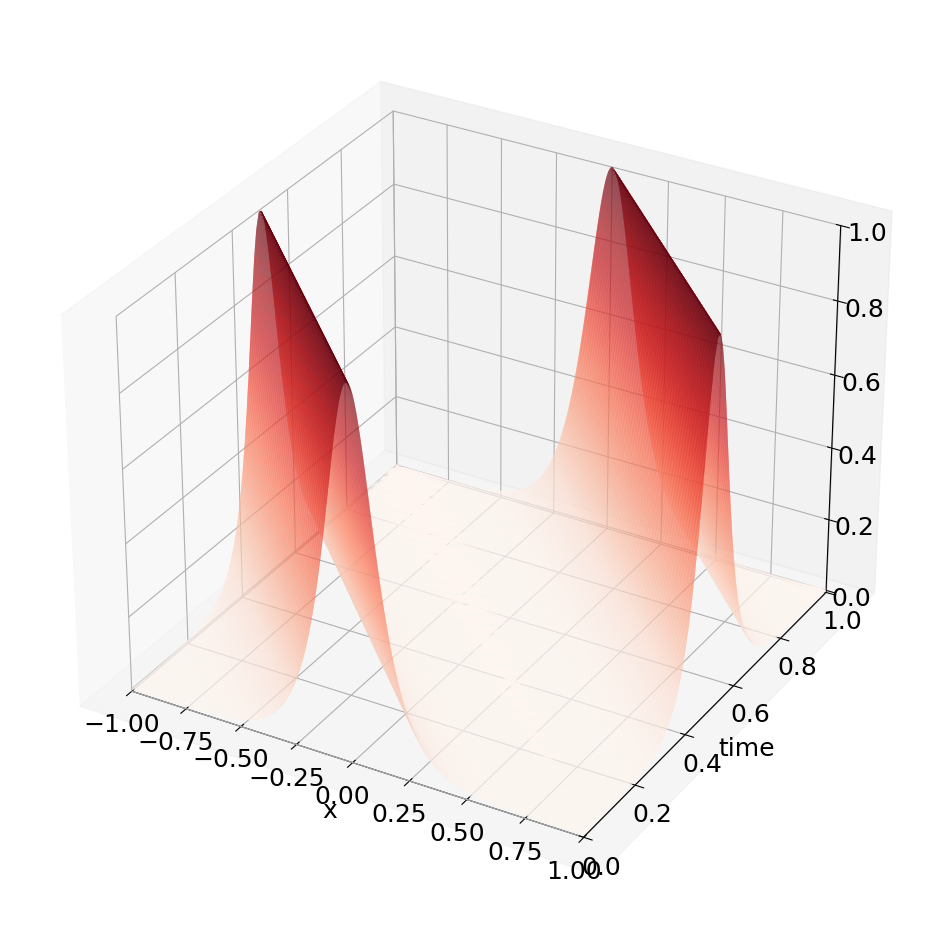

In [9]:
X, Y = np.meshgrid(x, t)
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, us.T,  cmap="Reds", antialiased=True, rstride=1,cstride=1);
ax.set_xlabel("x")
ax.set_ylabel("time");

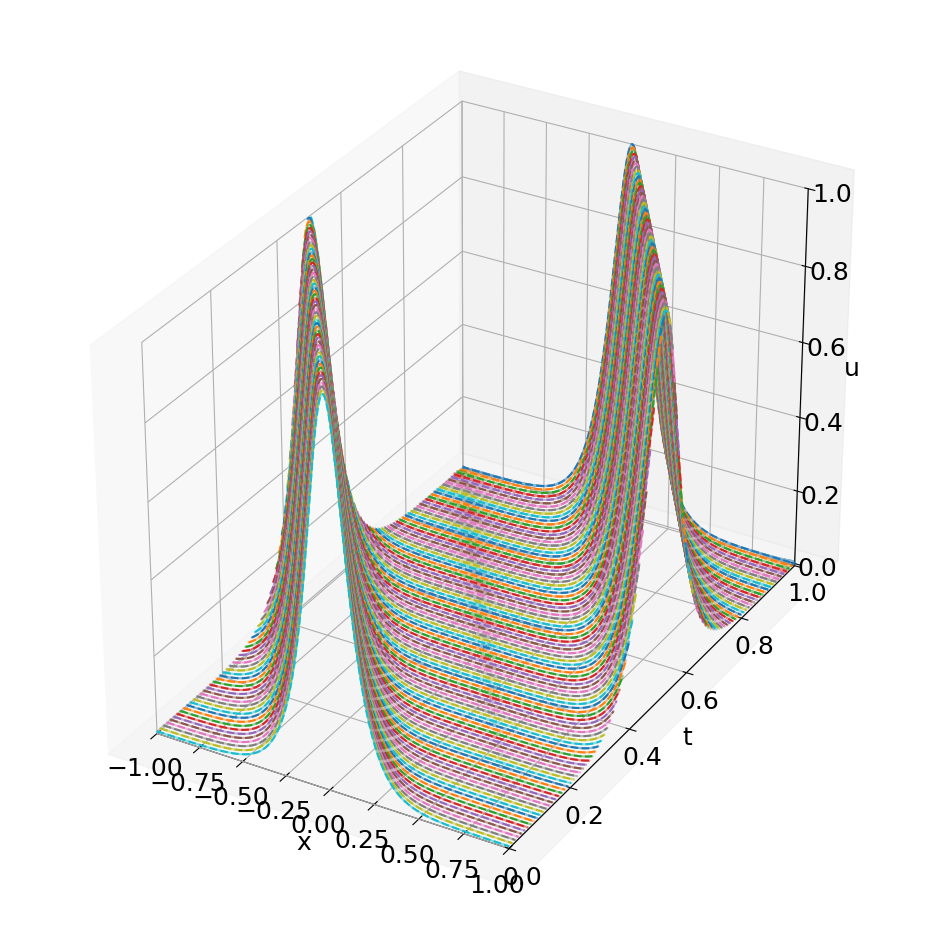

In [10]:
# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for j in range(u.shape[1]-1,-1,-1):
    ys = t[j]*np.ones(u.shape[0])
    color = next(ax._get_lines.prop_cycler)['color'] # cool trick to keep color 
    ax.plot(x,ys,us[:,j],'-',color=color,alpha=0.5)  # our spatial solution
    ax.plot(x,ys,u[:,j],'--',color=color)            # our Fourier solution
    
plt.xlabel("x")
plt.ylabel("t")

ax.set_zlabel("u")
ax.set_box_aspect([1, 1.5, 1])